In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from rdkit import Chem
from rdkit.Chem import AllChem
import lightgbm as lgb
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Function to generate Morgan fingerprints using the latest generator method
def generate_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        morgan_gen = AllChem.GetMorganGenerator(radius=radius, fpSize=nBits)
        return list(morgan_gen.GetFingerprint(mol))
    return [0] * nBits
dataset = pd.read_csv("dataset/SMRT_dataset_with_dates.csv").sort_values(by='date').reset_index(drop=True)
dataset['fingerprint'] = dataset['SMILES'].apply(lambda x: generate_fingerprint(x)) 

# LGBM models

## LGBM-random model

Training LightGBM model...


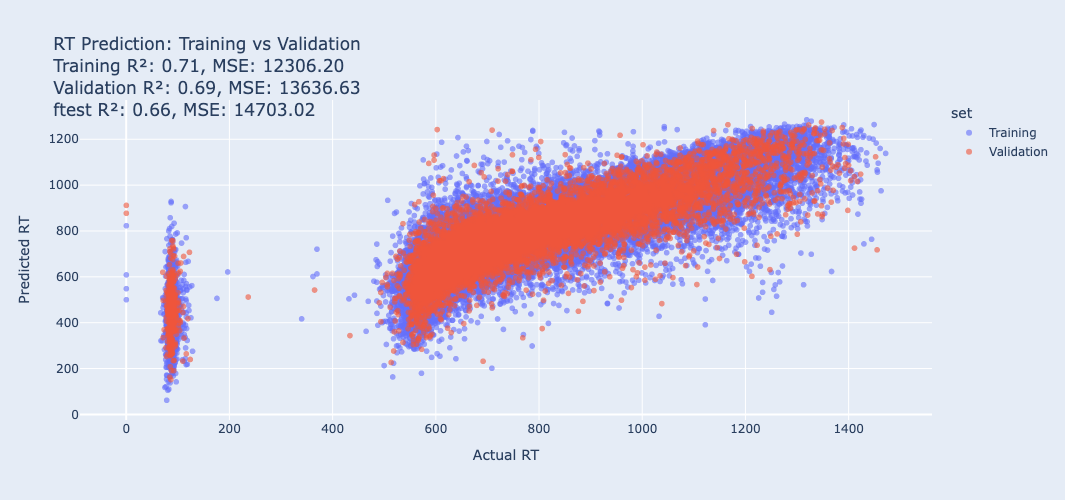

In [20]:
dataset_clean,ftest_set = dataset.iloc[:int(0.85*dataset.shape[0]),:],dataset.iloc[int(0.85*dataset.shape[0]):,]
# Randomly split the dataset into training and validation sets
train_set, valid_set = train_test_split(dataset_clean, test_size=0.176, random_state=42)

# Prepare data for LightGBM
X_train = np.array(train_set['fingerprint'].tolist())
y_train = train_set['rt']
X_valid = np.array(valid_set['fingerprint'].tolist())
y_valid = valid_set['rt']
X_ftest = np.array(ftest_set['fingerprint'].tolist())
y_ftest = ftest_set['rt']

# Train a LightGBM model with default parameters
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

print("Training LightGBM model...")
model = lgb.train({}, train_data, valid_sets=[valid_data])

# Make predictions on the training and validation sets
train_set['predicted_rt'] = model.predict(X_train)
valid_set['predicted_rt'] = model.predict(X_valid)

# Calculate R^2 and MSE for training and validation sets
train_r2 = r2_score(y_train, train_set['predicted_rt'])
train_mse = mean_squared_error(y_train, train_set['predicted_rt'])
valid_r2 = r2_score(y_valid, valid_set['predicted_rt'])
valid_mse = mean_squared_error(y_valid, valid_set['predicted_rt'])

ftest_r2 = r2_score(y_ftest, model.predict(X_ftest))
ftest_mse = mean_squared_error(y_ftest, model.predict(X_ftest))


# Combine training and validation for scatter plot
train_set['set'] = 'Training'
valid_set['set'] = 'Validation'
combined_data = pd.concat([train_set[['rt', 'predicted_rt', 'set']], valid_set[['rt', 'predicted_rt', 'set']]])

# Scatter plot for training and validation sets
title_text = (
    f"RT Prediction: Training vs Validation<br>"
    f"Training R²: {train_r2:.2f}, MSE: {train_mse:.2f}<br>"
    f"Validation R²: {valid_r2:.2f}, MSE: {valid_mse:.2f}<br>"
    f"ftest R²: {ftest_r2:.2f}, MSE: {ftest_mse:.2f}"
)

fig = px.scatter(
    combined_data, x='rt', y='predicted_rt', color='set',
    title=title_text,
    labels={'rt': 'Actual RT', 'predicted_rt': 'Predicted RT'},
    opacity=0.6
)

fig.update_layout(
    plot_bgcolor='rgba(229, 236, 246,1)',
    paper_bgcolor='rgba(229, 236, 246,1)',
    width=800,
    height=500
)

fig.show()

## Hyperparameters tuning for LGBM-random

In [ ]:
import optuna
import plotly.graph_objects as go
from IPython.display import display


def make_plotly_optuna_callback(
    title="Optuna Optimization Progress",
    yaxis_title="Objective Value",
):
    fig = go.FigureWidget()

    fig.add_scatter(
        x=[],
        y=[],
        mode="markers",
        name="Trial value",
        marker=dict(size=10)
    )

    fig.add_scatter(
        x=[],
        y=[],
        mode="lines+markers",
        name="Best so far"
    )

    fig.update_layout(
        title=title,
        plot_bgcolor='rgba(229, 236, 246,1)',
        paper_bgcolor='rgba(229, 236, 246,1)',
        xaxis_title="Trial",
        yaxis_title=yaxis_title,
    )

    display(fig)  # MUST be called once only

    def callback(study: optuna.Study, trial: optuna.trial.FrozenTrial):

        # Collect only completed trials
        trials = [t for t in study.trials if t.value is not None]
        if not trials:
            return

        xs = [t.number for t in trials]
        ys = [t.value for t in trials]

        # Compute running best
        best = []
        current = float("inf") if study.direction == optuna.study.StudyDirection.MINIMIZE else float("-inf")

        for v in ys:
            if study.direction == optuna.study.StudyDirection.MINIMIZE:
                current = min(current, v)
            else:
                current = max(current, v)
            best.append(current)

        with fig.batch_update():
            fig.data[0].x = xs
            fig.data[0].y = ys
            fig.data[1].x = xs
            fig.data[1].y = best

    return callback, fig

In [ ]:
from sklearn.metrics import mean_squared_error
import warnings

# Suppress the specific UserWarning about feature names
warnings.filterwarnings('ignore', category=UserWarning, 
                        message='X does not have valid feature names')


# Define the objective function for Optuna
def objective(trial):
    params = {
        "min_gain_to_split": 0.0,
        "min_data_in_leaf": 1,
        'n_estimators': trial.suggest_int('n_estimators', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 0.1, log=True),
    }

    # Perform cross-validation
    lgb_model = lgb.LGBMRegressor(**params,verbosity=-1)
    #mse = -cross_val_score(lgb_model, X_train, y_train, cv=5, scoring=make_scorer(mean_squared_error,greater_is_better=False)).mean()
    lgb_model.fit(X_train, y_train)
    valid_predictions = lgb_model.predict(X_valid)
    mse = mean_squared_error(y_valid, valid_predictions)
    return mse


cb, fig = make_plotly_optuna_callback(
    title="Visualization Optimization",
    yaxis_title="MSE"
)

study = optuna.create_study(direction="minimize")
study.optimize(
    objective,
    n_trials=50,
    callbacks=[cb]
)

FigureWidget({
    'data': [{'marker': {'size': 10},
              'mode': 'markers',
              'name': 'Trial value',
              'type': 'scatter',
              'uid': '21ad9c70-adca-4368-aec4-1aed3d433d99',
              'x': [],
              'y': []},
             {'mode': 'lines+markers',
              'name': 'Best so far',
              'type': 'scatter',
              'uid': 'e9dd5993-2720-4b53-83a5-af9178f66eda',
              'x': [],
              'y': []}],
    'layout': {'paper_bgcolor': 'rgba(229, 236, 246,1)',
               'plot_bgcolor': 'rgba(229, 236, 246,1)',
               'template': '...',
               'title': {'text': 'Visualization Optimization'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'MSE'}}}
})

[I 2025-12-29 15:37:56,899] A new study created in memory with name: no-name-1656afd8-5d01-460a-b642-6aa2390a245b
[I 2025-12-29 15:37:59,521] Trial 0 finished with value: 12475.554996121173 and parameters: {'n_estimators': 67, 'learning_rate': 0.4438680443965956, 'num_leaves': 294, 'max_depth': 26, 'min_child_samples': 10, 'reg_alpha': 0.0009336281721813285, 'reg_lambda': 0.0005709963032043467}. Best is trial 0 with value: 12475.554996121173.
[I 2025-12-29 15:38:02,465] Trial 1 finished with value: 10286.837906607767 and parameters: {'n_estimators': 82, 'learning_rate': 0.16574570866979663, 'num_leaves': 275, 'max_depth': 32, 'min_child_samples': 26, 'reg_alpha': 0.013152686157684211, 'reg_lambda': 0.0015634896827549992}. Best is trial 1 with value: 10286.837906607767.
[I 2025-12-29 15:38:04,195] Trial 2 finished with value: 18134.03618533232 and parameters: {'n_estimators': 74, 'learning_rate': 0.8899718871364183, 'num_leaves': 118, 'max_depth': 26, 'min_child_samples': 92, 'reg_alpha

## Reproduce the best for LGBM-random

Best parameters: {'n_estimators': 89, 'learning_rate': 0.14746423526060012, 'num_leaves': 209, 'max_depth': 36, 'min_child_samples': 26, 'reg_alpha': 0.0005322493996726818, 'reg_lambda': 0.0024563395221400787}


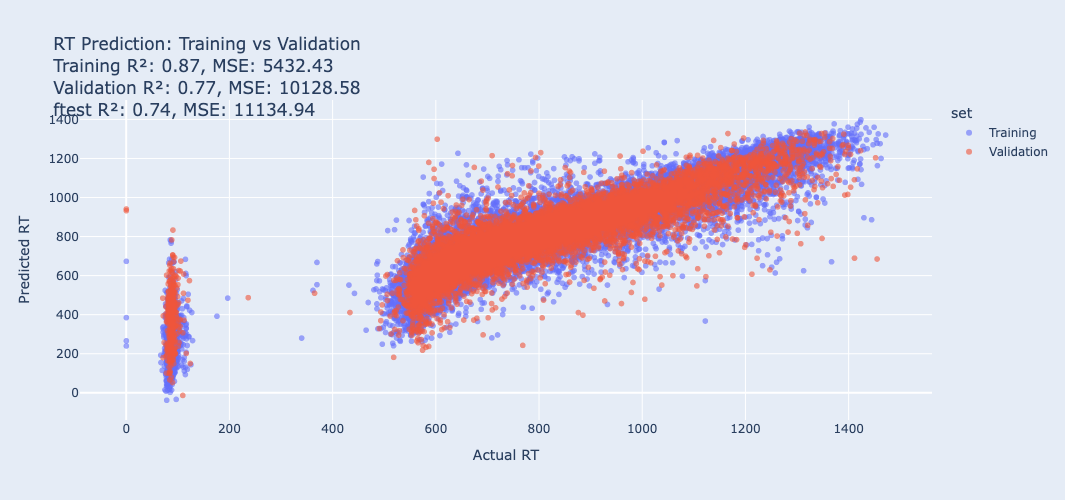

In [ ]:
# Get the best parameters
best_params = study.best_params
print("Best parameters:", best_params)

# Train the LightGBM model with the best parameters
model = lgb.LGBMRegressor(**best_params,verbosity=-1)
#model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# Make predictions on the training and validation sets
train_set['predicted_rt'] = model.predict(X_train)
valid_set['predicted_rt'] = model.predict(X_valid)

# Calculate R^2 and MSE for training and validation sets
train_r2 = r2_score(y_train, train_set['predicted_rt'])
train_mse = mean_squared_error(y_train, train_set['predicted_rt'])
valid_r2 = r2_score(y_valid, valid_set['predicted_rt'])
valid_mse = mean_squared_error(y_valid, valid_set['predicted_rt'])
ftest_r2 = r2_score(y_ftest, model.predict(X_ftest))
ftest_mse = mean_squared_error(y_ftest, model.predict(X_ftest))


# Combine training and validation for scatter plot
train_set['set'] = 'Training'
valid_set['set'] = 'Validation'
combined_data = pd.concat([train_set[['rt', 'predicted_rt', 'set']], valid_set[['rt', 'predicted_rt', 'set']]])

# Scatter plot for training and validation sets
title_text = (
    f"RT Prediction: Training vs Validation<br>"
    f"Training R²: {train_r2:.2f}, MSE: {train_mse:.2f}<br>"
    f"Validation R²: {valid_r2:.2f}, MSE: {valid_mse:.2f}<br>"
    f"ftest R²: {ftest_r2:.2f}, MSE: {ftest_mse:.2f}"
)

fig = px.scatter(
    combined_data, x='rt', y='predicted_rt', color='set',
    title=title_text,
    labels={'rt': 'Actual RT', 'predicted_rt': 'Predicted RT'},
    opacity=0.6
)

fig.update_layout(
    plot_bgcolor='rgba(229, 236, 246,1)',
    paper_bgcolor='rgba(229, 236, 246,1)',
    width=800,
    height=500
)

fig.show()

## LGBM-chronological Model

Training LightGBM model...


/tmp/ipykernel_1485/1072976084.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1485/1072976084.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1485/1072976084.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1

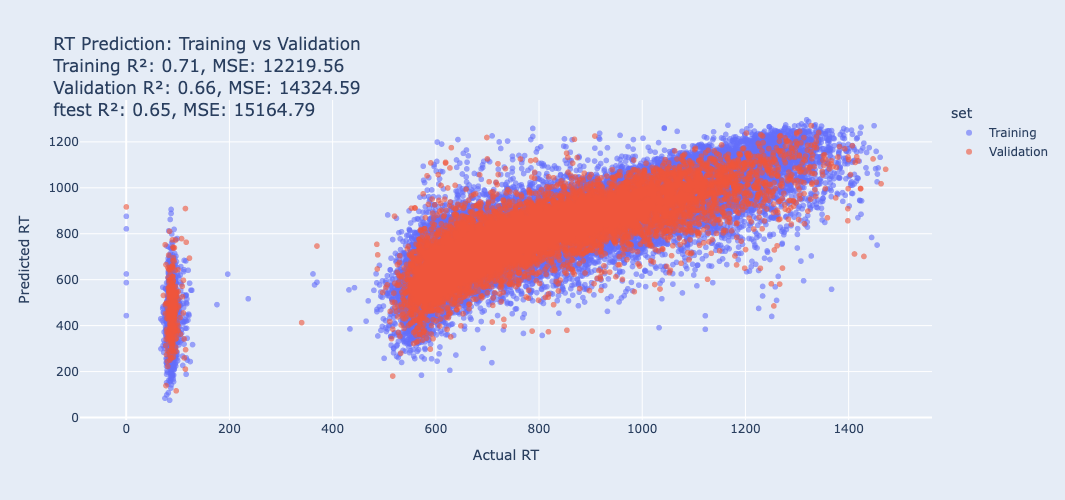

In [23]:
# Chronological split the dataset into training and validation sets
train_set, valid_set = dataset_clean.iloc[:int(0.824*dataset_clean.shape[0]),:], dataset_clean.iloc[int(0.824*dataset_clean.shape[0]):,:]

# Prepare data for LightGBM
X_train = np.array(train_set['fingerprint'].tolist())
y_train = train_set['rt']
X_valid = np.array(valid_set['fingerprint'].tolist())
y_valid = valid_set['rt']
X_ftest = np.array(ftest_set['fingerprint'].tolist())
y_ftest = ftest_set['rt']

# Train a LightGBM model with default parameters
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

print("Training LightGBM model...")
model = lgb.train({}, train_data, valid_sets=[valid_data])

# Make predictions on the training and validation sets
train_set['predicted_rt'] = model.predict(X_train)
valid_set['predicted_rt'] = model.predict(X_valid)

# Calculate R^2 and MSE for training and validation sets
train_r2 = r2_score(y_train, train_set['predicted_rt'])
train_mse = mean_squared_error(y_train, train_set['predicted_rt'])
valid_r2 = r2_score(y_valid, valid_set['predicted_rt'])
valid_mse = mean_squared_error(y_valid, valid_set['predicted_rt'])

ftest_r2 = r2_score(y_ftest, model.predict(X_ftest))
ftest_mse = mean_squared_error(y_ftest, model.predict(X_ftest))


# Combine training and validation for scatter plot
train_set['set'] = 'Training'
valid_set['set'] = 'Validation'
combined_data = pd.concat([train_set[['rt', 'predicted_rt', 'set']], valid_set[['rt', 'predicted_rt', 'set']]])

# Scatter plot for training and validation sets
title_text = (
    f"RT Prediction: Training vs Validation<br>"
    f"Training R²: {train_r2:.2f}, MSE: {train_mse:.2f}<br>"
    f"Validation R²: {valid_r2:.2f}, MSE: {valid_mse:.2f}<br>"
    f"ftest R²: {ftest_r2:.2f}, MSE: {ftest_mse:.2f}"
)

fig = px.scatter(
    combined_data, x='rt', y='predicted_rt', color='set',
    title=title_text,
    labels={'rt': 'Actual RT', 'predicted_rt': 'Predicted RT'},
    opacity=0.6
)

fig.update_layout(
    plot_bgcolor='rgba(229, 236, 246,1)',
    paper_bgcolor='rgba(229, 236, 246,1)',
    width=800,
    height=500
)

fig.show()

## Hyperparameters tuning for LGBM-chronological

In [ ]:
import plotly.graph_objects as go
import warnings

# Suppress the specific UserWarning about feature names
warnings.filterwarnings('ignore', category=UserWarning, 
                        message='X does not have valid feature names')


# Define the objective function for Optuna
def objective(trial):
    params = {
        "min_gain_to_split": 0.0,
        "min_data_in_leaf": 1,
        'n_estimators': trial.suggest_int('n_estimators', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 0.1, log=True),
    }

    # Perform cross-validation
    lgb_model = lgb.LGBMRegressor(**params,verbosity=-1)
    #mse = -cross_val_score(lgb_model, X_train, y_train, cv=5, scoring=make_scorer(mean_squared_error,greater_is_better=False)).mean()
    lgb_model.fit(X_train, y_train)
    valid_predictions = lgb_model.predict(X_valid)
    mse = mean_squared_error(y_valid, valid_predictions)
    return mse


cb, fig = make_plotly_optuna_callback(
    title="Visualization Optimization",
    yaxis_title="MSE"
)

study = optuna.create_study(direction="minimize")
study.optimize(
    objective,
    n_trials=50,
    callbacks=[cb]
)


FigureWidget({
    'data': [{'marker': {'size': 10},
              'mode': 'markers',
              'name': 'Trial value',
              'type': 'scatter',
              'uid': '7cc732a4-f503-400a-9226-e8d733cc06e4',
              'x': [],
              'y': []},
             {'mode': 'lines+markers',
              'name': 'Best so far',
              'type': 'scatter',
              'uid': 'b2eac8dc-8e4c-4626-bd00-b3848e30bb5e',
              'x': [],
              'y': []}],
    'layout': {'paper_bgcolor': 'rgba(229, 236, 246,1)',
               'plot_bgcolor': 'rgba(229, 236, 246,1)',
               'template': '...',
               'title': {'text': 'Visualization Optimization'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'MSE'}}}
})

[I 2025-12-29 15:40:57,963] A new study created in memory with name: no-name-4bec34f4-3781-4217-a610-8b04c4fc48b3
[I 2025-12-29 15:40:59,284] Trial 0 finished with value: 15226.835516598092 and parameters: {'n_estimators': 50, 'learning_rate': 0.6471577897663922, 'num_leaves': 79, 'max_depth': 34, 'min_child_samples': 61, 'reg_alpha': 0.0034160512753633665, 'reg_lambda': 0.0026748923500864307}. Best is trial 0 with value: 15226.835516598092.
[I 2025-12-29 15:41:01,020] Trial 1 finished with value: 12596.083926550858 and parameters: {'n_estimators': 42, 'learning_rate': 0.289960049773025, 'num_leaves': 255, 'max_depth': 22, 'min_child_samples': 46, 'reg_alpha': 0.08020372372439283, 'reg_lambda': 0.002310606767721837}. Best is trial 1 with value: 12596.083926550858.
[I 2025-12-29 15:41:02,109] Trial 2 finished with value: 16156.179493136486 and parameters: {'n_estimators': 23, 'learning_rate': 0.1850269165320817, 'num_leaves': 81, 'max_depth': 40, 'min_child_samples': 99, 'reg_alpha': 0.

[I 2025-12-22 15:14:12,633] Trial 0 finished with value: 13996.640789858735 and parameters: {'n_estimators': 49, 'learning_rate': 0.4688951267456498, 'num_leaves': 247, 'max_depth': 13, 'min_child_samples': 73, 'reg_alpha': 0.002108411551961366, 'reg_lambda': 0.0020166439961425003}. Best is trial 0 with value: 13996.640789858735.
[I 2025-12-22 15:14:36,358] Trial 1 finished with value: 14446.417832174955 and parameters: {'n_estimators': 67, 'learning_rate': 0.5394318324742686, 'num_leaves': 191, 'max_depth': 39, 'min_child_samples': 63, 'reg_alpha': 0.0006455090671622542, 'reg_lambda': 0.02155444139938929}. Best is trial 0 with value: 13996.640789858735.
[I 2025-12-22 15:15:19,636] Trial 2 finished with value: 11753.785023777158 and parameters: {'n_estimators': 96, 'learning_rate': 0.07300636642942446, 'num_leaves': 272, 'max_depth': 50, 'min_child_samples': 74, 'reg_alpha': 0.0004030310771538315, 'reg_lambda': 0.0001360188629569451}. Best is trial 2 with value: 11753.785023777158.
[I 

## Reproduce the best for LGBM-chronological


Best parameters: {'n_estimators': 85, 'learning_rate': 0.1687182779628331, 'num_leaves': 250, 'max_depth': 44, 'min_child_samples': 61, 'reg_alpha': 0.0444389796945603, 'reg_lambda': 0.009807436772453925}


/tmp/ipykernel_1485/981232737.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1485/981232737.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1485/981232737.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1485

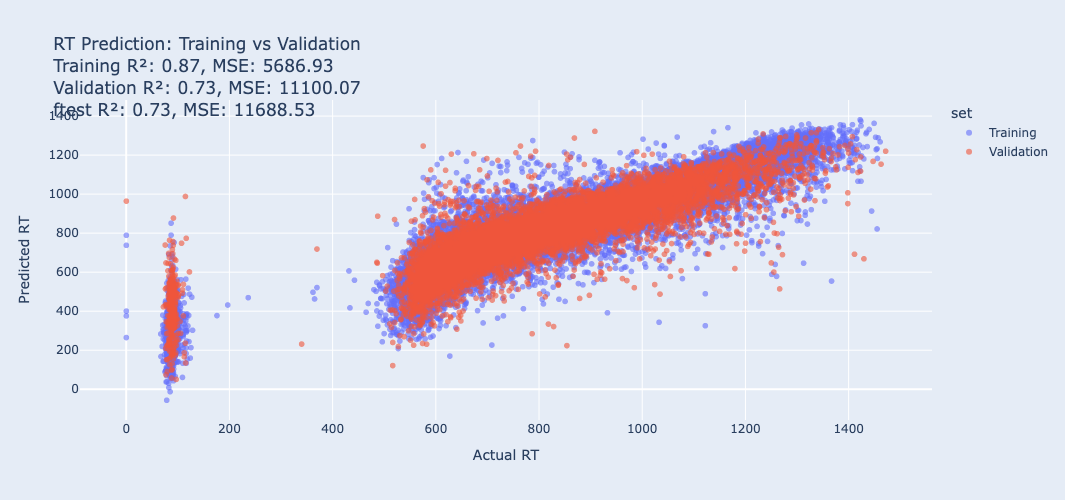

In [26]:
# Get the best parameters
best_params = study.best_params
print("Best parameters:", best_params)

# Train the LightGBM model with the best parameters
model = lgb.LGBMRegressor(**best_params,verbosity=-1)
#model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# Make predictions on the training and validation sets
train_set['predicted_rt'] = model.predict(X_train)
valid_set['predicted_rt'] = model.predict(X_valid)

# Calculate R^2 and MSE for training and validation sets
train_r2 = r2_score(y_train, train_set['predicted_rt'])
train_mse = mean_squared_error(y_train, train_set['predicted_rt'])
valid_r2 = r2_score(y_valid, valid_set['predicted_rt'])
valid_mse = mean_squared_error(y_valid, valid_set['predicted_rt'])
ftest_r2 = r2_score(y_ftest, model.predict(X_ftest))
ftest_mse = mean_squared_error(y_ftest, model.predict(X_ftest))


# Combine training and validation for scatter plot
train_set['set'] = 'Training'
valid_set['set'] = 'Validation'
combined_data = pd.concat([train_set[['rt', 'predicted_rt', 'set']], valid_set[['rt', 'predicted_rt', 'set']]])

# Scatter plot for training and validation sets
title_text = (
    f"RT Prediction: Training vs Validation<br>"
    f"Training R²: {train_r2:.2f}, MSE: {train_mse:.2f}<br>"
    f"Validation R²: {valid_r2:.2f}, MSE: {valid_mse:.2f}<br>"
    f"ftest R²: {ftest_r2:.2f}, MSE: {ftest_mse:.2f}"
)

fig = px.scatter(
    combined_data, x='rt', y='predicted_rt', color='set',
    title=title_text,
    labels={'rt': 'Actual RT', 'predicted_rt': 'Predicted RT'},
    opacity=0.6
)

fig.update_layout(
    plot_bgcolor='rgba(229, 236, 246,1)',
    paper_bgcolor='rgba(229, 236, 246,1)',
    width=800,
    height=500
)

fig.show()


# Graphic Neural Networks

## GCN-random model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from pyg_chemprop_utils import smiles2data,initialize_weights
from pyg_chemprop import GCNEncoder,train,make_prediction
from torch_geometric.loader import DataLoader
import torch


dataset = pd.read_csv("dataset/SMRT_dataset_with_dates.csv").sort_values(by='date').reset_index(drop=True)
dataset_clean = dataset.iloc[:int(0.85*dataset.shape[0]),:]
ftest_set = dataset.iloc[int(0.85*dataset.shape[0]):,]
# Randomly split the dataset into training and validation sets
train_set, valid_set = train_test_split(dataset_clean, test_size=0.176, random_state=42)

# Build graph dataset from train/valid splits
smiles_col = "SMILES"  
rt_col = "rt"          
train_graphs = []
for _, row in train_set.iterrows():
    data = smiles2data(row[smiles_col])
    data['y'] = row[rt_col]
    if data is not None:
        train_graphs.append(data)

valid_graphs = []
for _, row in valid_set.iterrows():
    data = smiles2data(row[smiles_col])
    data['y'] = row[rt_col]
    if data is not None:
        valid_graphs.append(data)

ftest_graphs = []
for _, row in ftest_set.iterrows():
    data = smiles2data(row[smiles_col])
    data['y'] = row[rt_col]
    if data is not None:
        ftest_graphs.append(data)
len(train_graphs), len(valid_graphs), len(ftest_graphs)

(56058, 11974, 12006)

In [ ]:
batch_size=128
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_graphs, batch_size=batch_size, shuffle=False)
ftest_loader = DataLoader(ftest_graphs, batch_size=batch_size, shuffle=False)

In [64]:
num_epochs = 50
hidden_size = 512
depth = 3
out_dim = 1
dropout = 0.1

In [65]:
from torch import nn
head = nn.Sequential(
    nn.Linear(hidden_size, hidden_size, bias=True),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size//2, bias=True),
    nn.ReLU(),
    nn.Linear(hidden_size//2, out_dim, bias=True),
)
model = nn.Sequential(
    GCNEncoder(
        hidden_size,
        train_loader.dataset[0].num_node_features,
        depth,
        dropout=dropout
    ),
    head,
)
initialize_weights(model)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=num_epochs
)
config = {
    "loss": criterion,
    "model": model,
    "optimizer": optimizer,
    "scheduler": scheduler,
}

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    train(config, train_loader)
    y_pred, y_true = make_prediction(config, valid_loader)
    mse = mean_squared_error(y_true, y_pred.squeeze())
    r2 = r2_score(y_true, y_pred.squeeze())
    print(f"val r2={r2:.4} mse={mse:.4}")

In [68]:
train_y_pred, train_y_true = make_prediction(config, train_loader)
train_mse = mean_squared_error(train_y_true, train_y_pred.squeeze())
train_r2 = r2_score(train_y_true, train_y_pred.squeeze())
print(f"train r2={train_r2:.4} mse={train_mse:.4}")
valid_y_pred, valid_y_true = make_prediction(config, valid_loader)
valid_mse = mean_squared_error(valid_y_true, valid_y_pred.squeeze())
valid_r2 = r2_score(valid_y_true, valid_y_pred.squeeze())
print(f"valid r2={valid_r2:.4} mse={valid_mse:.4}")
ftest_y_pred, ftest_y_true = make_prediction(config, ftest_loader)
ftest_mse = mean_squared_error(ftest_y_true, ftest_y_pred.squeeze())
ftest_r2 = r2_score(ftest_y_true, ftest_y_pred.squeeze())
print(f"ftest r2={ftest_r2:.4} mse={ftest_mse:.4}")

100%|██████████| 438/438 [00:04<00:00, 109.38it/s]


train r2=0.7565 mse=1.033e+04


100%|██████████| 94/94 [00:00<00:00, 152.60it/s]


valid r2=0.7572 mse=1.052e+04


100%|██████████| 94/94 [00:00<00:00, 137.08it/s]

ftest r2=0.739 mse=1.133e+04


## Hyperparameters tuning for GCN-randomm

In [ ]:
import optuna
from torch import nn
import warnings
from pyg_chemprop import train_silent

# Suppress warnings
warnings.filterwarnings('ignore')

def objective(trial):
    # Hyperparameters to optimize
    hidden_size = trial.suggest_categorical('hidden_size', [128, 256, 512])
    depth = trial.suggest_int('depth', 2, 5)
    dropout = trial.suggest_float('dropout', 0.01, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    num_epochs = trial.suggest_int('num_epochs', 10, 100)
    
    
    # Using train_graphs and valid_graphs from the global scope
    train_loader_trial = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    valid_loader_trial = DataLoader(valid_graphs, batch_size=batch_size, shuffle=False)
    
    # Model definition
    out_dim = 1
    head = nn.Sequential(
        nn.Linear(hidden_size, hidden_size, bias=True),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_size, hidden_size//2, bias=True),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_size//2, out_dim, bias=True),
    )
    
    model = nn.Sequential(
        GCNEncoder(
            hidden_size,
            train_graphs[0].num_node_features,
            depth,
            dropout=dropout
        ),
        head,
    )
    initialize_weights(model)
    
    # Training setup
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=learning_rate*10, steps_per_epoch=len(train_loader_trial), epochs=num_epochs
    )
    
    config = {
        "loss": criterion,
        "model": model,
        "optimizer": optimizer,
        "scheduler": scheduler,
    }
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Training loop
    for epoch in range(num_epochs):
        train_silent(config, train_loader_trial, device=device)
        
    # Final Evaluation
    y_pred, y_true = make_prediction(config, valid_loader_trial, device=device)
    mse = mean_squared_error(y_true, y_pred.squeeze())
    
    return mse

# Visualization callback
cb, fig = make_plotly_optuna_callback(
    title="GCN Hyperparameter Optimization",
    yaxis_title="MSE"
)

# Run optimization
study_gcn = optuna.create_study(direction="minimize")
study_gcn.optimize(
    objective,
    n_trials=50,
    callbacks=[cb]
)

FigureWidget({
    'data': [{'marker': {'size': 10},
              'mode': 'markers',
              'name': 'Trial value',
              'type': 'scatter',
              'uid': 'fafffab1-dc05-4a79-8820-b4da6f285be8',
              'x': [],
              'y': []},
             {'mode': 'lines+markers',
              'name': 'Best so far',
              'type': 'scatter',
              'uid': '2df9293a-3cd8-478f-9947-52c25cdd4f0d',
              'x': [],
              'y': []}],
    'layout': {'paper_bgcolor': 'rgba(229, 236, 246,1)',
               'plot_bgcolor': 'rgba(229, 236, 246,1)',
               'template': '...',
               'title': {'text': 'GCN Hyperparameter Optimization'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'MSE'}}}
})

[I 2025-12-29 20:55:17,122] A new study created in memory with name: no-name-46b2e95d-e0e5-4680-82be-63091775028b
100%|██████████| 94/94 [00:00<00:00, 139.52it/s]
[I 2025-12-29 20:56:38,256] Trial 0 finished with value: 16236.568359375 and parameters: {'hidden_size': 256, 'depth': 3, 'dropout': 0.3254454852349138, 'learning_rate': 0.00015791923738111622, 'batch_size': 128, 'num_epochs': 20}. Best is trial 0 with value: 16236.568359375.
100%|██████████| 94/94 [00:00<00:00, 148.46it/s]
[I 2025-12-29 20:57:54,490] Trial 1 finished with value: 16042.3427734375 and parameters: {'hidden_size': 128, 'depth': 2, 'dropout': 0.0113963639442197, 'learning_rate': 0.0009156084801199652, 'batch_size': 128, 'num_epochs': 21}. Best is trial 1 with value: 16042.3427734375.
100%|██████████| 94/94 [00:00<00:00, 144.64it/s]
[I 2025-12-29 20:59:26,452] Trial 2 finished with value: 13692.7197265625 and parameters: {'hidden_size': 256, 'depth': 2, 'dropout': 0.1047256675162845, 'learning_rate': 0.00285092911

## Reproduce the best  for GCN-random

In [ ]:
# Get the best parameters
best_params = study_gcn.best_params
print("Best parameters:", best_params)

# Extract params
hidden_size = best_params['hidden_size']
depth = best_params['depth']
dropout = best_params['dropout']
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']
num_epochs = best_params['num_epochs']

# Recreate loaders with best batch size
train_loader_best = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
valid_loader_best = DataLoader(valid_graphs, batch_size=batch_size, shuffle=False)
ftest_loader_best = DataLoader(ftest_graphs, batch_size=batch_size, shuffle=False)

# Rebuild model
out_dim = 1
head = nn.Sequential(
    nn.Linear(hidden_size, hidden_size, bias=True),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden_size, hidden_size//2, bias=True),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden_size//2, out_dim, bias=True),
)

model = nn.Sequential(
    GCNEncoder(
        hidden_size,
        train_graphs[0].num_node_features,
        depth,
        dropout=dropout
    ),
    head,
)
initialize_weights(model)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
#num_epochs = 50 # Full training
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=learning_rate*10, steps_per_epoch=len(train_loader_best), epochs=num_epochs
)

config = {
    "loss": criterion,
    "model": model,
    "optimizer": optimizer,
    "scheduler": scheduler,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    train(config, train_loader_best, device=device) # Use the original train with tqdm
    y_pred, y_true = make_prediction(config, valid_loader_best, device=device)
    mse = mean_squared_error(y_true, y_pred.squeeze())
    r2 = r2_score(y_true, y_pred.squeeze())
    print(f"val r2={r2:.4} mse={mse:.4}")

# Final evaluation
train_y_pred, train_y_true = make_prediction(config, train_loader_best, device=device)
train_mse = mean_squared_error(train_y_true, train_y_pred.squeeze())
train_r2 = r2_score(train_y_true, train_y_pred.squeeze())
print(f"train r2={train_r2:.4} mse={train_mse:.4}")

valid_y_pred, valid_y_true = make_prediction(config, valid_loader_best, device=device)
valid_mse = mean_squared_error(valid_y_true, valid_y_pred.squeeze())
valid_r2 = r2_score(valid_y_true, valid_y_pred.squeeze())
print(f"valid r2={valid_r2:.4} mse={valid_mse:.4}")

ftest_y_pred, ftest_y_true = make_prediction(config, ftest_loader_best, device=device)
ftest_mse = mean_squared_error(ftest_y_true, ftest_y_pred.squeeze())
ftest_r2 = r2_score(ftest_y_true, ftest_y_pred.squeeze())
print(f"ftest r2={ftest_r2:.4} mse={ftest_mse:.4}")

Best parameters: {'hidden_size': 512, 'depth': 5, 'dropout': 0.14273760144541264, 'learning_rate': 0.0005503715417544122, 'batch_size': 256, 'num_epochs': 98}
Epoch 1


100%|██████████| 47/47 [00:00<00:00, 82.52it/s]


val r2=0.1137 mse=3.84e+04
Epoch 2


100%|██████████| 47/47 [00:00<00:00, 82.24it/s]


val r2=0.1637 mse=3.624e+04
Epoch 3


100%|██████████| 47/47 [00:00<00:00, 79.73it/s]


val r2=0.2942 mse=3.058e+04
Epoch 4


100%|██████████| 47/47 [00:01<00:00, 42.32it/s]


val r2=0.3874 mse=2.654e+04
Epoch 5


100%|██████████| 47/47 [00:00<00:00, 78.56it/s]


val r2=0.4335 mse=2.455e+04
Epoch 6


100%|██████████| 47/47 [00:00<00:00, 79.55it/s]


val r2=0.4689 mse=2.301e+04
Epoch 7


100%|██████████| 47/47 [00:00<00:00, 79.89it/s]


val r2=0.5547 mse=1.929e+04
Epoch 8


100%|██████████| 47/47 [00:00<00:00, 81.31it/s]


val r2=0.5875 mse=1.787e+04
Epoch 9


100%|██████████| 47/47 [00:00<00:00, 79.71it/s]


val r2=0.5743 mse=1.845e+04
Epoch 10


100%|██████████| 47/47 [00:00<00:00, 81.90it/s]


val r2=0.5206 mse=2.077e+04
Epoch 11


100%|██████████| 47/47 [00:00<00:00, 82.11it/s]


val r2=0.6375 mse=1.57e+04
Epoch 12


100%|██████████| 47/47 [00:00<00:00, 81.16it/s]


val r2=0.4591 mse=2.344e+04
Epoch 13


100%|██████████| 47/47 [00:00<00:00, 80.99it/s]


val r2=0.672 mse=1.421e+04
Epoch 14


100%|██████████| 47/47 [00:00<00:00, 82.73it/s]


val r2=0.427 mse=2.483e+04
Epoch 15


100%|██████████| 47/47 [00:00<00:00, 82.99it/s]


val r2=0.6889 mse=1.348e+04
Epoch 16


100%|██████████| 47/47 [00:00<00:00, 84.18it/s]


val r2=0.5422 mse=1.984e+04
Epoch 17


100%|██████████| 47/47 [00:00<00:00, 82.48it/s]


val r2=0.6559 mse=1.491e+04
Epoch 18


100%|██████████| 47/47 [00:00<00:00, 80.93it/s]


val r2=0.6605 mse=1.471e+04
Epoch 19


100%|██████████| 47/47 [00:00<00:00, 80.19it/s]


val r2=0.6869 mse=1.357e+04
Epoch 20


100%|██████████| 47/47 [00:01<00:00, 42.33it/s]


val r2=0.7092 mse=1.26e+04
Epoch 21


100%|██████████| 47/47 [00:00<00:00, 79.13it/s]


val r2=0.6774 mse=1.398e+04
Epoch 22


100%|██████████| 47/47 [00:00<00:00, 80.78it/s]


val r2=0.7051 mse=1.278e+04
Epoch 23


100%|██████████| 47/47 [00:00<00:00, 81.77it/s]


val r2=0.6608 mse=1.47e+04
Epoch 24


100%|██████████| 47/47 [00:00<00:00, 80.87it/s]


val r2=0.6842 mse=1.368e+04
Epoch 25


100%|██████████| 47/47 [00:00<00:00, 79.31it/s]


val r2=0.7221 mse=1.204e+04
Epoch 26


100%|██████████| 47/47 [00:00<00:00, 81.56it/s]


val r2=0.7178 mse=1.223e+04
Epoch 27


100%|██████████| 47/47 [00:00<00:00, 81.56it/s]


val r2=0.7418 mse=1.119e+04
Epoch 28


100%|██████████| 47/47 [00:00<00:00, 82.25it/s]


val r2=0.6139 mse=1.673e+04
Epoch 29


100%|██████████| 47/47 [00:00<00:00, 84.20it/s]


val r2=0.7388 mse=1.132e+04
Epoch 30


100%|██████████| 47/47 [00:00<00:00, 83.57it/s]


val r2=0.7431 mse=1.113e+04
Epoch 31


100%|██████████| 47/47 [00:00<00:00, 81.38it/s]


val r2=0.735 mse=1.148e+04
Epoch 32


100%|██████████| 47/47 [00:00<00:00, 81.70it/s]


val r2=0.7559 mse=1.058e+04
Epoch 33


100%|██████████| 47/47 [00:00<00:00, 82.48it/s]


val r2=0.7495 mse=1.085e+04
Epoch 34


100%|██████████| 47/47 [00:00<00:00, 81.35it/s]


val r2=0.744 mse=1.109e+04
Epoch 35


100%|██████████| 47/47 [00:00<00:00, 79.63it/s]


val r2=0.7704 mse=9.949e+03
Epoch 36


100%|██████████| 47/47 [00:01<00:00, 43.33it/s]


val r2=0.7554 mse=1.06e+04
Epoch 37


100%|██████████| 47/47 [00:00<00:00, 81.72it/s]


val r2=0.699 mse=1.304e+04
Epoch 38


100%|██████████| 47/47 [00:00<00:00, 78.75it/s]


val r2=0.7589 mse=1.045e+04
Epoch 39


100%|██████████| 47/47 [00:00<00:00, 81.00it/s]


val r2=0.7826 mse=9.422e+03
Epoch 40


100%|██████████| 47/47 [00:00<00:00, 82.72it/s]


val r2=0.7587 mse=1.046e+04
Epoch 41


100%|██████████| 47/47 [00:00<00:00, 82.64it/s]


val r2=0.7739 mse=9.796e+03
Epoch 42


100%|██████████| 47/47 [00:00<00:00, 82.99it/s]


val r2=0.7874 mse=9.213e+03
Epoch 43


100%|██████████| 47/47 [00:00<00:00, 83.38it/s]


val r2=0.7836 mse=9.375e+03
Epoch 44


100%|██████████| 47/47 [00:00<00:00, 84.24it/s]


val r2=0.7913 mse=9.042e+03
Epoch 45


100%|██████████| 47/47 [00:00<00:00, 84.57it/s]


val r2=0.783 mse=9.402e+03
Epoch 46


100%|██████████| 47/47 [00:00<00:00, 81.25it/s]


val r2=0.7911 mse=9.053e+03
Epoch 47


100%|██████████| 47/47 [00:00<00:00, 81.98it/s]


val r2=0.7595 mse=1.042e+04
Epoch 48


100%|██████████| 47/47 [00:00<00:00, 82.72it/s]


val r2=0.7898 mse=9.106e+03
Epoch 49


100%|██████████| 47/47 [00:00<00:00, 81.94it/s]


val r2=0.799 mse=8.707e+03
Epoch 50


100%|██████████| 47/47 [00:00<00:00, 77.98it/s]


val r2=0.8045 mse=8.47e+03
Epoch 51


100%|██████████| 47/47 [00:00<00:00, 79.30it/s]


val r2=0.7911 mse=9.052e+03
Epoch 52


100%|██████████| 47/47 [00:01<00:00, 43.02it/s]


val r2=0.8045 mse=8.469e+03
Epoch 53


100%|██████████| 47/47 [00:00<00:00, 79.27it/s]


val r2=0.8069 mse=8.369e+03
Epoch 54


100%|██████████| 47/47 [00:00<00:00, 80.50it/s]


val r2=0.7871 mse=9.225e+03
Epoch 55


100%|██████████| 47/47 [00:00<00:00, 80.94it/s]


val r2=0.7965 mse=8.818e+03
Epoch 56


100%|██████████| 47/47 [00:00<00:00, 80.99it/s]


val r2=0.8014 mse=8.605e+03
Epoch 57


100%|██████████| 47/47 [00:00<00:00, 82.18it/s]


val r2=0.813 mse=8.103e+03
Epoch 58


100%|██████████| 47/47 [00:00<00:00, 83.14it/s]


val r2=0.8112 mse=8.179e+03
Epoch 59


100%|██████████| 47/47 [00:00<00:00, 82.77it/s]


val r2=0.8037 mse=8.504e+03
Epoch 60


100%|██████████| 47/47 [00:00<00:00, 82.80it/s]


val r2=0.8084 mse=8.3e+03
Epoch 61


100%|██████████| 47/47 [00:00<00:00, 81.02it/s]


val r2=0.8151 mse=8.011e+03
Epoch 62


100%|██████████| 47/47 [00:00<00:00, 81.78it/s]


val r2=0.8182 mse=7.876e+03
Epoch 63


100%|██████████| 47/47 [00:00<00:00, 81.09it/s]


val r2=0.8164 mse=7.956e+03
Epoch 64


100%|██████████| 47/47 [00:00<00:00, 80.37it/s]


val r2=0.8126 mse=8.12e+03
Epoch 65


100%|██████████| 47/47 [00:00<00:00, 82.25it/s]


val r2=0.8179 mse=7.892e+03
Epoch 66


100%|██████████| 47/47 [00:00<00:00, 79.47it/s]


val r2=0.8185 mse=7.864e+03
Epoch 67


100%|██████████| 47/47 [00:00<00:00, 79.20it/s]


val r2=0.8224 mse=7.694e+03
Epoch 68


100%|██████████| 47/47 [00:00<00:00, 77.38it/s]


val r2=0.8169 mse=7.932e+03
Epoch 69


100%|██████████| 47/47 [00:00<00:00, 77.53it/s]


val r2=0.8224 mse=7.693e+03
Epoch 70


100%|██████████| 47/47 [00:00<00:00, 78.28it/s]


val r2=0.8152 mse=8.009e+03
Epoch 71


100%|██████████| 47/47 [00:00<00:00, 81.86it/s]


val r2=0.8253 mse=7.569e+03
Epoch 72


100%|██████████| 47/47 [00:00<00:00, 82.17it/s]


val r2=0.8251 mse=7.578e+03
Epoch 73


100%|██████████| 47/47 [00:00<00:00, 83.08it/s]


val r2=0.8276 mse=7.472e+03
Epoch 74


100%|██████████| 47/47 [00:00<00:00, 83.93it/s]


val r2=0.8271 mse=7.492e+03
Epoch 75


100%|██████████| 47/47 [00:00<00:00, 80.76it/s]


val r2=0.825 mse=7.583e+03
Epoch 76


100%|██████████| 47/47 [00:00<00:00, 81.82it/s]


val r2=0.8268 mse=7.503e+03
Epoch 77


100%|██████████| 47/47 [00:00<00:00, 82.33it/s]


val r2=0.8311 mse=7.317e+03
Epoch 78


100%|██████████| 47/47 [00:00<00:00, 81.83it/s]


val r2=0.8309 mse=7.326e+03
Epoch 79


100%|██████████| 47/47 [00:00<00:00, 80.74it/s]


val r2=0.8313 mse=7.309e+03
Epoch 80


100%|██████████| 47/47 [00:00<00:00, 80.67it/s]


val r2=0.8309 mse=7.329e+03
Epoch 81


100%|██████████| 47/47 [00:00<00:00, 78.77it/s]


val r2=0.8325 mse=7.258e+03
Epoch 82


100%|██████████| 47/47 [00:00<00:00, 77.79it/s]


val r2=0.8297 mse=7.379e+03
Epoch 83


100%|██████████| 47/47 [00:00<00:00, 79.10it/s]


val r2=0.8322 mse=7.269e+03
Epoch 84


100%|██████████| 47/47 [00:00<00:00, 79.53it/s]


val r2=0.8321 mse=7.273e+03
Epoch 85


100%|██████████| 47/47 [00:01<00:00, 43.04it/s]


val r2=0.8337 mse=7.208e+03
Epoch 86


100%|██████████| 47/47 [00:00<00:00, 81.26it/s]


val r2=0.8346 mse=7.166e+03
Epoch 87


100%|██████████| 47/47 [00:00<00:00, 83.99it/s]


val r2=0.8356 mse=7.124e+03
Epoch 88


100%|██████████| 47/47 [00:00<00:00, 82.40it/s]


val r2=0.8349 mse=7.155e+03
Epoch 89


100%|██████████| 47/47 [00:00<00:00, 81.42it/s]


val r2=0.8342 mse=7.186e+03
Epoch 90


100%|██████████| 47/47 [00:00<00:00, 81.47it/s]


val r2=0.8353 mse=7.135e+03
Epoch 91


100%|██████████| 47/47 [00:00<00:00, 81.02it/s]


val r2=0.8328 mse=7.244e+03
Epoch 92


100%|██████████| 47/47 [00:00<00:00, 80.40it/s]


val r2=0.8353 mse=7.136e+03
Epoch 93


100%|██████████| 47/47 [00:00<00:00, 82.17it/s]


val r2=0.8356 mse=7.123e+03
Epoch 94


100%|██████████| 47/47 [00:00<00:00, 84.03it/s]


val r2=0.8356 mse=7.125e+03
Epoch 95


100%|██████████| 47/47 [00:00<00:00, 80.96it/s]


val r2=0.8356 mse=7.125e+03
Epoch 96


100%|██████████| 47/47 [00:00<00:00, 79.95it/s]


val r2=0.8355 mse=7.126e+03
Epoch 97


100%|██████████| 47/47 [00:00<00:00, 78.92it/s]


val r2=0.8354 mse=7.131e+03
Epoch 98


100%|██████████| 47/47 [00:00<00:00, 80.14it/s]


val r2=0.8355 mse=7.129e+03


100%|██████████| 219/219 [00:03<00:00, 61.61it/s]


train r2=0.8737 mse=5.36e+03


100%|██████████| 47/47 [00:00<00:00, 76.56it/s]


valid r2=0.8355 mse=7.129e+03


100%|██████████| 47/47 [00:00<00:00, 68.77it/s]

ftest r2=0.8241 mse=7.634e+03


In [71]:
torch.save(model,'random_best_model.pt')

## GCN-chronological model

In [48]:
dataset = pd.read_csv("dataset/SMRT_dataset_with_dates.csv").sort_values(by='date').reset_index(drop=True)
dataset_clean = dataset.iloc[:int(0.85*dataset.shape[0]),:]
ftest_set = dataset.iloc[int(0.85*dataset.shape[0]):,]
train_set,valid_set = dataset_clean.iloc[:int(0.824*dataset_clean.shape[0]),:], dataset_clean.iloc[int(0.824*dataset_clean.shape[0]):,:]
# Build graph dataset from train/valid splits
smiles_col = "SMILES"  # change if your column name differs
rt_col = "rt"          # change if your column name differs

train_graphs = []
for _, row in train_set.iterrows():
    data = smiles2data(row[smiles_col])
    data['y'] = row[rt_col]
    if data is not None:
        train_graphs.append(data)

valid_graphs = []
for _, row in valid_set.iterrows():
    data = smiles2data(row[smiles_col])
    data['y'] = row[rt_col]
    if data is not None:
        valid_graphs.append(data)

ftest_graphs = []
for _, row in ftest_set.iterrows():
    data = smiles2data(row[smiles_col])
    data['y'] = row[rt_col]
    if data is not None:
        ftest_graphs.append(data)
len(train_graphs), len(valid_graphs), len(ftest_graphs)

(56058, 11974, 12006)

In [ ]:
from pyg_chemprop import GCNEncoder
from torch_geometric.loader import DataLoader



batch_size=128
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_graphs, batch_size=batch_size, shuffle=False)
ftest_loader = DataLoader(ftest_graphs, batch_size=batch_size, shuffle=False)

In [50]:
from torch import nn
head = nn.Sequential(
    nn.Linear(hidden_size, hidden_size, bias=True),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size//2, bias=True),
    nn.ReLU(),
    nn.Linear(hidden_size//2, out_dim, bias=True),
)
model = nn.Sequential(
    GCNEncoder(
        hidden_size,
        train_loader.dataset[0].num_node_features,
        depth,
        dropout=dropout
    ),
    head,
)
initialize_weights(model)

In [51]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=num_epochs
)
config = {
    "loss": criterion,
    "model": model,
    "optimizer": optimizer,
    "scheduler": scheduler,
}

In [52]:
from sklearn.metrics import mean_squared_error, r2_score
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    train(config, train_loader)
    y_pred, y_true = make_prediction(config, valid_loader)
    mse = mean_squared_error(y_true, y_pred.squeeze())
    r2 = r2_score(y_true, y_pred.squeeze())
    print(f"val r2={r2:.4} mse={mse:.4}")

Epoch 1


100%|██████████| 94/94 [00:00<00:00, 139.21it/s]


val r2=0.06622 mse=3.882e+04
Epoch 2


100%|██████████| 94/94 [00:00<00:00, 140.33it/s]


val r2=0.1251 mse=3.637e+04
Epoch 3


100%|██████████| 94/94 [00:00<00:00, 140.81it/s]


val r2=0.1651 mse=3.47e+04
Epoch 4


100%|██████████| 94/94 [00:01<00:00, 83.01it/s] 


val r2=0.2413 mse=3.154e+04
Epoch 5


100%|██████████| 94/94 [00:00<00:00, 141.09it/s]


val r2=0.3493 mse=2.705e+04
Epoch 6


100%|██████████| 94/94 [00:00<00:00, 145.91it/s]


val r2=0.4099 mse=2.453e+04
Epoch 7


100%|██████████| 94/94 [00:00<00:00, 141.47it/s]


val r2=0.4153 mse=2.431e+04
Epoch 8


100%|██████████| 94/94 [00:00<00:00, 144.36it/s]


val r2=0.4584 mse=2.251e+04
Epoch 9


100%|██████████| 94/94 [00:00<00:00, 147.31it/s]


val r2=0.4872 mse=2.132e+04
Epoch 10


100%|██████████| 94/94 [00:00<00:00, 146.62it/s]


val r2=0.4804 mse=2.16e+04
Epoch 11


100%|██████████| 94/94 [00:00<00:00, 149.16it/s]


val r2=0.5174 mse=2.006e+04
Epoch 12


100%|██████████| 94/94 [00:00<00:00, 143.10it/s]


val r2=0.5095 mse=2.039e+04
Epoch 13


100%|██████████| 94/94 [00:00<00:00, 137.19it/s]


val r2=0.4672 mse=2.215e+04
Epoch 14


100%|██████████| 94/94 [00:00<00:00, 138.04it/s]


val r2=0.5593 mse=1.832e+04
Epoch 15


100%|██████████| 94/94 [00:00<00:00, 139.46it/s]


val r2=0.5433 mse=1.899e+04
Epoch 16


100%|██████████| 94/94 [00:00<00:00, 141.79it/s]


val r2=0.5605 mse=1.827e+04
Epoch 17


100%|██████████| 94/94 [00:00<00:00, 150.74it/s]


val r2=0.576 mse=1.762e+04
Epoch 18


100%|██████████| 94/94 [00:00<00:00, 149.23it/s]


val r2=0.5185 mse=2.002e+04
Epoch 19


100%|██████████| 94/94 [00:00<00:00, 148.59it/s]


val r2=0.6212 mse=1.575e+04
Epoch 20


100%|██████████| 94/94 [00:01<00:00, 82.95it/s] 


val r2=0.6352 mse=1.516e+04
Epoch 21


100%|██████████| 94/94 [00:00<00:00, 149.88it/s]


val r2=0.6337 mse=1.523e+04
Epoch 22


100%|██████████| 94/94 [00:00<00:00, 151.35it/s]


val r2=0.5621 mse=1.82e+04
Epoch 23


100%|██████████| 94/94 [00:00<00:00, 150.14it/s]


val r2=0.6499 mse=1.455e+04
Epoch 24


100%|██████████| 94/94 [00:00<00:00, 149.47it/s]


val r2=0.658 mse=1.421e+04
Epoch 25


100%|██████████| 94/94 [00:00<00:00, 147.33it/s]


val r2=0.662 mse=1.405e+04
Epoch 26


100%|██████████| 94/94 [00:00<00:00, 144.57it/s]


val r2=0.6615 mse=1.407e+04
Epoch 27


100%|██████████| 94/94 [00:00<00:00, 146.51it/s]


val r2=0.6359 mse=1.514e+04
Epoch 28


100%|██████████| 94/94 [00:00<00:00, 142.14it/s]


val r2=0.6753 mse=1.35e+04
Epoch 29


100%|██████████| 94/94 [00:00<00:00, 143.89it/s]


val r2=0.6689 mse=1.376e+04
Epoch 30


100%|██████████| 94/94 [00:00<00:00, 142.48it/s]


val r2=0.6776 mse=1.34e+04
Epoch 31


100%|██████████| 94/94 [00:00<00:00, 145.05it/s]


val r2=0.6925 mse=1.278e+04
Epoch 32


100%|██████████| 94/94 [00:00<00:00, 145.73it/s]


val r2=0.6925 mse=1.278e+04
Epoch 33


100%|██████████| 94/94 [00:00<00:00, 142.74it/s]


val r2=0.6974 mse=1.258e+04
Epoch 34


100%|██████████| 94/94 [00:00<00:00, 143.45it/s]


val r2=0.6514 mse=1.449e+04
Epoch 35


100%|██████████| 94/94 [00:00<00:00, 141.72it/s]


val r2=0.6988 mse=1.252e+04
Epoch 36


100%|██████████| 94/94 [00:00<00:00, 147.49it/s]


val r2=0.6871 mse=1.301e+04
Epoch 37


100%|██████████| 94/94 [00:01<00:00, 76.45it/s] 


val r2=0.7087 mse=1.211e+04
Epoch 38


100%|██████████| 94/94 [00:00<00:00, 144.86it/s]


val r2=0.7013 mse=1.242e+04
Epoch 39


100%|██████████| 94/94 [00:00<00:00, 140.78it/s]


val r2=0.7081 mse=1.213e+04
Epoch 40


100%|██████████| 94/94 [00:00<00:00, 123.94it/s]


val r2=0.7126 mse=1.195e+04
Epoch 41


100%|██████████| 94/94 [00:00<00:00, 140.71it/s]


val r2=0.7103 mse=1.204e+04
Epoch 42


100%|██████████| 94/94 [00:00<00:00, 140.74it/s]


val r2=0.7178 mse=1.173e+04
Epoch 43


100%|██████████| 94/94 [00:00<00:00, 142.17it/s]


val r2=0.7174 mse=1.175e+04
Epoch 44


100%|██████████| 94/94 [00:00<00:00, 144.37it/s]


val r2=0.7196 mse=1.166e+04
Epoch 45


100%|██████████| 94/94 [00:00<00:00, 145.09it/s]


val r2=0.7205 mse=1.162e+04
Epoch 46


100%|██████████| 94/94 [00:00<00:00, 145.72it/s]


val r2=0.7194 mse=1.166e+04
Epoch 47


100%|██████████| 94/94 [00:00<00:00, 144.48it/s]


val r2=0.7212 mse=1.159e+04
Epoch 48


100%|██████████| 94/94 [00:00<00:00, 145.88it/s]


val r2=0.7208 mse=1.16e+04
Epoch 49


100%|██████████| 94/94 [00:00<00:00, 141.94it/s]


val r2=0.7213 mse=1.159e+04
Epoch 50


100%|██████████| 94/94 [00:00<00:00, 142.90it/s]

val r2=0.7216 mse=1.157e+04


In [53]:
train_y_pred, train_y_true = make_prediction(config, train_loader)
train_mse = mean_squared_error(train_y_true, train_y_pred.squeeze())
train_r2 = r2_score(train_y_true, train_y_pred.squeeze())
print(f"train r2={train_r2:.4} mse={train_mse:.4}")
valid_y_pred, valid_y_true = make_prediction(config, valid_loader)
valid_mse = mean_squared_error(valid_y_true, valid_y_pred.squeeze())
valid_r2 = r2_score(valid_y_true, valid_y_pred.squeeze())
print(f"valid r2={valid_r2:.4} mse={valid_mse:.4}")
ftest_y_pred, ftest_y_true = make_prediction(config, ftest_loader)
ftest_mse = mean_squared_error(ftest_y_true, ftest_y_pred.squeeze())
ftest_r2 = r2_score(ftest_y_true, ftest_y_pred.squeeze())
print(f"ftest r2={ftest_r2:.4} mse={ftest_mse:.4}")

100%|██████████| 438/438 [00:03<00:00, 113.48it/s]


train r2=0.7635 mse=1.012e+04


100%|██████████| 94/94 [00:00<00:00, 142.45it/s]


valid r2=0.7216 mse=1.157e+04


100%|██████████| 94/94 [00:00<00:00, 129.10it/s]

ftest r2=0.7391 mse=1.132e+04


## Hyperparameters tuning for GCN-chronological

In [ ]:
import optuna
from torch import nn
import warnings
from pyg_chemprop import train_silent

# Suppress warnings
warnings.filterwarnings('ignore')

def objective(trial):
    # Hyperparameters to optimize
    hidden_size = trial.suggest_categorical('hidden_size', [128, 256, 512])
    depth = trial.suggest_int('depth', 2, 5)
    dropout = trial.suggest_float('dropout', 0.01, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    num_epochs = trial.suggest_int('num_epochs', 10, 100)
    
    
    # Using train_graphs and valid_graphs from the global scope
    train_loader_trial = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    valid_loader_trial = DataLoader(valid_graphs, batch_size=batch_size, shuffle=False)
    
    # Model definition
    out_dim = 1
    head = nn.Sequential(
        nn.Linear(hidden_size, hidden_size, bias=True),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_size, hidden_size//2, bias=True),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_size//2, out_dim, bias=True),
    )
    
    model = nn.Sequential(
        GCNEncoder(
            hidden_size,
            train_graphs[0].num_node_features,
            depth,
            dropout=dropout
        ),
        head,
    )
    initialize_weights(model)
    
    # Training setup
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=learning_rate*10, steps_per_epoch=len(train_loader_trial), epochs=num_epochs
    )
    
    config = {
        "loss": criterion,
        "model": model,
        "optimizer": optimizer,
        "scheduler": scheduler,
    }
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Training loop
    for epoch in range(num_epochs):
        train_silent(config, train_loader_trial, device=device)
        
    # Final Evaluation
    y_pred, y_true = make_prediction(config, valid_loader_trial, device=device)
    mse = mean_squared_error(y_true, y_pred.squeeze())
    
    return mse

# Visualization callback
cb, fig = make_plotly_optuna_callback(
    title="GCN Hyperparameter Optimization",
    yaxis_title="MSE"
)

# Run optimization
study_gcn = optuna.create_study(direction="minimize")
study_gcn.optimize(
    objective,
    n_trials=50,
    callbacks=[cb]
)

FigureWidget({
    'data': [{'marker': {'size': 10},
              'mode': 'markers',
              'name': 'Trial value',
              'type': 'scatter',
              'uid': '6afa551a-3bc2-4d87-b334-5256308e65ca',
              'x': [],
              'y': []},
             {'mode': 'lines+markers',
              'name': 'Best so far',
              'type': 'scatter',
              'uid': '46f18c6b-8457-46e7-ba92-d493ff6b11f8',
              'x': [],
              'y': []}],
    'layout': {'paper_bgcolor': 'rgba(229, 236, 246,1)',
               'plot_bgcolor': 'rgba(229, 236, 246,1)',
               'template': '...',
               'title': {'text': 'GCN Hyperparameter Optimization'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'MSE'}}}
})

[I 2025-12-29 16:23:22,566] A new study created in memory with name: no-name-c512db8e-c95a-4cd4-894e-8eb3ac894d27
100%|██████████| 24/24 [00:00<00:00, 39.25it/s]
[I 2025-12-29 16:24:10,345] Trial 0 finished with value: 16567.642578125 and parameters: {'hidden_size': 512, 'depth': 4, 'dropout': 0.31971303743741036, 'learning_rate': 0.0003920404788379779, 'batch_size': 512, 'num_epochs': 17}. Best is trial 0 with value: 16567.642578125.
100%|██████████| 24/24 [00:00<00:00, 47.20it/s]
[I 2025-12-29 16:25:34,766] Trial 1 finished with value: 22863.912109375 and parameters: {'hidden_size': 128, 'depth': 2, 'dropout': 0.4156750025117704, 'learning_rate': 0.0001939689405944356, 'batch_size': 512, 'num_epochs': 35}. Best is trial 0 with value: 16567.642578125.
100%|██████████| 24/24 [00:00<00:00, 47.35it/s]
[I 2025-12-29 16:27:29,392] Trial 2 finished with value: 20511.857421875 and parameters: {'hidden_size': 128, 'depth': 3, 'dropout': 0.48774054637512465, 'learning_rate': 0.0003251887590472

## Reproduce the best model for GCN-chronological

In [ ]:
# Get the best parameters
best_params = study_gcn.best_params
print("Best parameters:", best_params)

# Extract params
hidden_size = best_params['hidden_size']
depth = best_params['depth']
dropout = best_params['dropout']
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']
num_epochs = best_params['num_epochs']

# Recreate loaders with best batch size
train_loader_best = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
valid_loader_best = DataLoader(valid_graphs, batch_size=batch_size, shuffle=False)
ftest_loader_best = DataLoader(ftest_graphs, batch_size=batch_size, shuffle=False)

# Rebuild model
out_dim = 1
head = nn.Sequential(
    nn.Linear(hidden_size, hidden_size, bias=True),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden_size, hidden_size//2, bias=True),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden_size//2, out_dim, bias=True),
)

model = nn.Sequential(
    GCNEncoder(
        hidden_size,
        train_graphs[0].num_node_features,
        depth,
        dropout=dropout
    ),
    head,
)
initialize_weights(model)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
#num_epochs = 50 # Full training
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=learning_rate*10, steps_per_epoch=len(train_loader_best), epochs=num_epochs
)

config = {
    "loss": criterion,
    "model": model,
    "optimizer": optimizer,
    "scheduler": scheduler,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    train(config, train_loader_best, device=device) # Use the original train with tqdm
    y_pred, y_true = make_prediction(config, valid_loader_best, device=device)
    mse = mean_squared_error(y_true, y_pred.squeeze())
    r2 = r2_score(y_true, y_pred.squeeze())
    print(f"val r2={r2:.4} mse={mse:.4}")

# Final evaluation
train_y_pred, train_y_true = make_prediction(config, train_loader_best, device=device)
train_mse = mean_squared_error(train_y_true, train_y_pred.squeeze())
train_r2 = r2_score(train_y_true, train_y_pred.squeeze())
print(f"train r2={train_r2:.4} mse={train_mse:.4}")

valid_y_pred, valid_y_true = make_prediction(config, valid_loader_best, device=device)
valid_mse = mean_squared_error(valid_y_true, valid_y_pred.squeeze())
valid_r2 = r2_score(valid_y_true, valid_y_pred.squeeze())
print(f"valid r2={valid_r2:.4} mse={valid_mse:.4}")

ftest_y_pred, ftest_y_true = make_prediction(config, ftest_loader_best, device=device)
ftest_mse = mean_squared_error(ftest_y_true, ftest_y_pred.squeeze())
ftest_r2 = r2_score(ftest_y_true, ftest_y_pred.squeeze())
print(f"ftest r2={ftest_r2:.4} mse={ftest_mse:.4}")

Best parameters: {'hidden_size': 256, 'depth': 5, 'dropout': 0.14056941754998398, 'learning_rate': 0.00048634508950476987, 'batch_size': 128, 'num_epochs': 99}
Epoch 1


100%|██████████| 94/94 [00:00<00:00, 142.75it/s]


val r2=0.1228 mse=3.646e+04
Epoch 2


100%|██████████| 94/94 [00:00<00:00, 134.50it/s]


val r2=0.1893 mse=3.37e+04
Epoch 3


100%|██████████| 94/94 [00:00<00:00, 124.62it/s]


val r2=0.2742 mse=3.017e+04
Epoch 4


100%|██████████| 94/94 [00:01<00:00, 74.44it/s] 


val r2=0.3451 mse=2.722e+04
Epoch 5


100%|██████████| 94/94 [00:00<00:00, 136.03it/s]


val r2=0.3983 mse=2.501e+04
Epoch 6


100%|██████████| 94/94 [00:00<00:00, 132.97it/s]


val r2=0.4344 mse=2.351e+04
Epoch 7


100%|██████████| 94/94 [00:00<00:00, 133.90it/s]


val r2=0.541 mse=1.908e+04
Epoch 8


100%|██████████| 94/94 [00:00<00:00, 128.47it/s]


val r2=0.5325 mse=1.943e+04
Epoch 9


100%|██████████| 94/94 [00:00<00:00, 130.04it/s]


val r2=0.5587 mse=1.834e+04
Epoch 10


100%|██████████| 94/94 [00:00<00:00, 134.70it/s]


val r2=0.5981 mse=1.671e+04
Epoch 11


100%|██████████| 94/94 [00:00<00:00, 135.14it/s]


val r2=0.5923 mse=1.695e+04
Epoch 12


100%|██████████| 94/94 [00:00<00:00, 133.59it/s]


val r2=0.6337 mse=1.523e+04
Epoch 13


100%|██████████| 94/94 [00:00<00:00, 130.77it/s]


val r2=0.6304 mse=1.536e+04
Epoch 14


100%|██████████| 94/94 [00:00<00:00, 130.26it/s]


val r2=0.5338 mse=1.938e+04
Epoch 15


100%|██████████| 94/94 [00:00<00:00, 135.49it/s]


val r2=0.6418 mse=1.489e+04
Epoch 16


100%|██████████| 94/94 [00:00<00:00, 132.23it/s]


val r2=0.6591 mse=1.417e+04
Epoch 17


100%|██████████| 94/94 [00:00<00:00, 133.62it/s]


val r2=0.6688 mse=1.377e+04
Epoch 18


100%|██████████| 94/94 [00:00<00:00, 127.91it/s]


val r2=0.6081 mse=1.629e+04
Epoch 19


100%|██████████| 94/94 [00:00<00:00, 132.54it/s]


val r2=0.6821 mse=1.321e+04
Epoch 20


100%|██████████| 94/94 [00:00<00:00, 138.05it/s]


val r2=0.677 mse=1.343e+04
Epoch 21


100%|██████████| 94/94 [00:00<00:00, 133.16it/s]


val r2=0.6804 mse=1.329e+04
Epoch 22


100%|██████████| 94/94 [00:01<00:00, 79.52it/s] 


val r2=0.6806 mse=1.328e+04
Epoch 23


100%|██████████| 94/94 [00:00<00:00, 141.93it/s]


val r2=0.6955 mse=1.266e+04
Epoch 24


100%|██████████| 94/94 [00:00<00:00, 135.76it/s]


val r2=0.6877 mse=1.298e+04
Epoch 25


100%|██████████| 94/94 [00:00<00:00, 140.11it/s]


val r2=0.6948 mse=1.269e+04
Epoch 26


100%|██████████| 94/94 [00:00<00:00, 131.47it/s]


val r2=0.6896 mse=1.29e+04
Epoch 27


100%|██████████| 94/94 [00:00<00:00, 136.05it/s]


val r2=0.7066 mse=1.22e+04
Epoch 28


100%|██████████| 94/94 [00:00<00:00, 133.58it/s]


val r2=0.659 mse=1.417e+04
Epoch 29


100%|██████████| 94/94 [00:00<00:00, 134.64it/s]


val r2=0.6578 mse=1.422e+04
Epoch 30


100%|██████████| 94/94 [00:00<00:00, 137.00it/s]


val r2=0.6616 mse=1.407e+04
Epoch 31


100%|██████████| 94/94 [00:00<00:00, 137.32it/s]


val r2=0.7239 mse=1.148e+04
Epoch 32


100%|██████████| 94/94 [00:00<00:00, 138.87it/s]


val r2=0.7128 mse=1.194e+04
Epoch 33


100%|██████████| 94/94 [00:00<00:00, 132.16it/s]


val r2=0.7306 mse=1.12e+04
Epoch 34


100%|██████████| 94/94 [00:00<00:00, 138.44it/s]


val r2=0.7071 mse=1.218e+04
Epoch 35


100%|██████████| 94/94 [00:00<00:00, 132.90it/s]


val r2=0.7488 mse=1.044e+04
Epoch 36


100%|██████████| 94/94 [00:00<00:00, 133.73it/s]


val r2=0.7446 mse=1.062e+04
Epoch 37


100%|██████████| 94/94 [00:00<00:00, 131.43it/s]


val r2=0.7358 mse=1.098e+04
Epoch 38


100%|██████████| 94/94 [00:01<00:00, 75.90it/s] 


val r2=0.7239 mse=1.148e+04
Epoch 39


100%|██████████| 94/94 [00:00<00:00, 131.10it/s]


val r2=0.7507 mse=1.036e+04
Epoch 40


100%|██████████| 94/94 [00:00<00:00, 137.57it/s]


val r2=0.7598 mse=9.983e+03
Epoch 41


100%|██████████| 94/94 [00:00<00:00, 136.65it/s]


val r2=0.7523 mse=1.03e+04
Epoch 42


100%|██████████| 94/94 [00:00<00:00, 134.31it/s]


val r2=0.7588 mse=1.003e+04
Epoch 43


100%|██████████| 94/94 [00:00<00:00, 135.68it/s]


val r2=0.7551 mse=1.018e+04
Epoch 44


100%|██████████| 94/94 [00:00<00:00, 133.57it/s]


val r2=0.7649 mse=9.772e+03
Epoch 45


100%|██████████| 94/94 [00:00<00:00, 136.54it/s]


val r2=0.769 mse=9.601e+03
Epoch 46


100%|██████████| 94/94 [00:00<00:00, 132.98it/s]


val r2=0.7642 mse=9.803e+03
Epoch 47


100%|██████████| 94/94 [00:00<00:00, 129.17it/s]


val r2=0.7667 mse=9.696e+03
Epoch 48


100%|██████████| 94/94 [00:00<00:00, 132.45it/s]


val r2=0.7491 mse=1.043e+04
Epoch 49


100%|██████████| 94/94 [00:00<00:00, 129.48it/s]


val r2=0.7575 mse=1.008e+04
Epoch 50


100%|██████████| 94/94 [00:00<00:00, 134.57it/s]


val r2=0.7324 mse=1.112e+04
Epoch 51


100%|██████████| 94/94 [00:00<00:00, 137.97it/s]


val r2=0.7699 mse=9.563e+03
Epoch 52


100%|██████████| 94/94 [00:00<00:00, 139.85it/s]


val r2=0.7762 mse=9.305e+03
Epoch 53


100%|██████████| 94/94 [00:00<00:00, 140.19it/s]


val r2=0.7796 mse=9.163e+03
Epoch 54


100%|██████████| 94/94 [00:00<00:00, 141.01it/s]


val r2=0.7781 mse=9.225e+03
Epoch 55


100%|██████████| 94/94 [00:01<00:00, 79.07it/s] 


val r2=0.76 mse=9.977e+03
Epoch 56


100%|██████████| 94/94 [00:00<00:00, 139.56it/s]


val r2=0.7879 mse=8.815e+03
Epoch 57


100%|██████████| 94/94 [00:00<00:00, 135.40it/s]


val r2=0.7884 mse=8.794e+03
Epoch 58


100%|██████████| 94/94 [00:00<00:00, 134.80it/s]


val r2=0.7893 mse=8.758e+03
Epoch 59


100%|██████████| 94/94 [00:00<00:00, 133.16it/s]


val r2=0.7893 mse=8.76e+03
Epoch 60


100%|██████████| 94/94 [00:00<00:00, 136.66it/s]


val r2=0.7644 mse=9.794e+03
Epoch 61


100%|██████████| 94/94 [00:00<00:00, 138.84it/s]


val r2=0.7931 mse=8.601e+03
Epoch 62


100%|██████████| 94/94 [00:00<00:00, 138.54it/s]


val r2=0.783 mse=9.022e+03
Epoch 63


100%|██████████| 94/94 [00:00<00:00, 128.93it/s]


val r2=0.7929 mse=8.608e+03
Epoch 64


100%|██████████| 94/94 [00:00<00:00, 135.83it/s]


val r2=0.7969 mse=8.444e+03
Epoch 65


100%|██████████| 94/94 [00:00<00:00, 131.50it/s]


val r2=0.7985 mse=8.375e+03
Epoch 66


100%|██████████| 94/94 [00:00<00:00, 130.07it/s]


val r2=0.7999 mse=8.319e+03
Epoch 67


100%|██████████| 94/94 [00:00<00:00, 126.45it/s]


val r2=0.7993 mse=8.344e+03
Epoch 68


100%|██████████| 94/94 [00:00<00:00, 129.69it/s]


val r2=0.8009 mse=8.277e+03
Epoch 69


100%|██████████| 94/94 [00:00<00:00, 133.05it/s]


val r2=0.7944 mse=8.546e+03
Epoch 70


100%|██████████| 94/94 [00:00<00:00, 132.36it/s]


val r2=0.8033 mse=8.175e+03
Epoch 71


100%|██████████| 94/94 [00:00<00:00, 138.65it/s]


val r2=0.8011 mse=8.268e+03
Epoch 72


100%|██████████| 94/94 [00:01<00:00, 79.46it/s] 


val r2=0.8002 mse=8.306e+03
Epoch 73


100%|██████████| 94/94 [00:00<00:00, 134.18it/s]


val r2=0.8014 mse=8.255e+03
Epoch 74


100%|██████████| 94/94 [00:00<00:00, 138.07it/s]


val r2=0.8004 mse=8.295e+03
Epoch 75


100%|██████████| 94/94 [00:00<00:00, 133.93it/s]


val r2=0.8072 mse=8.016e+03
Epoch 76


100%|██████████| 94/94 [00:00<00:00, 142.78it/s]


val r2=0.8084 mse=7.966e+03
Epoch 77


100%|██████████| 94/94 [00:00<00:00, 132.60it/s]


val r2=0.8077 mse=7.994e+03
Epoch 78


100%|██████████| 94/94 [00:00<00:00, 137.43it/s]


val r2=0.8087 mse=7.952e+03
Epoch 79


100%|██████████| 94/94 [00:00<00:00, 126.63it/s]


val r2=0.8078 mse=7.991e+03
Epoch 80


100%|██████████| 94/94 [00:00<00:00, 130.95it/s]


val r2=0.8114 mse=7.839e+03
Epoch 81


100%|██████████| 94/94 [00:00<00:00, 134.84it/s]


val r2=0.812 mse=7.816e+03
Epoch 82


100%|██████████| 94/94 [00:00<00:00, 140.03it/s]


val r2=0.8134 mse=7.758e+03
Epoch 83


100%|██████████| 94/94 [00:00<00:00, 140.10it/s]


val r2=0.8127 mse=7.786e+03
Epoch 84


100%|██████████| 94/94 [00:00<00:00, 136.88it/s]


val r2=0.8138 mse=7.739e+03
Epoch 85


100%|██████████| 94/94 [00:00<00:00, 139.97it/s]


val r2=0.812 mse=7.814e+03
Epoch 86


100%|██████████| 94/94 [00:00<00:00, 141.84it/s]


val r2=0.8126 mse=7.788e+03
Epoch 87


100%|██████████| 94/94 [00:00<00:00, 137.13it/s]


val r2=0.8153 mse=7.677e+03
Epoch 88


100%|██████████| 94/94 [00:00<00:00, 132.39it/s]


val r2=0.8152 mse=7.68e+03
Epoch 89


100%|██████████| 94/94 [00:01<00:00, 78.95it/s] 


val r2=0.8156 mse=7.665e+03
Epoch 90


100%|██████████| 94/94 [00:00<00:00, 132.55it/s]


val r2=0.8174 mse=7.59e+03
Epoch 91


100%|██████████| 94/94 [00:00<00:00, 141.14it/s]


val r2=0.8165 mse=7.626e+03
Epoch 92


100%|██████████| 94/94 [00:00<00:00, 141.87it/s]


val r2=0.8159 mse=7.654e+03
Epoch 93


100%|██████████| 94/94 [00:00<00:00, 135.26it/s]


val r2=0.817 mse=7.607e+03
Epoch 94


100%|██████████| 94/94 [00:00<00:00, 135.90it/s]


val r2=0.8173 mse=7.596e+03
Epoch 95


100%|██████████| 94/94 [00:00<00:00, 134.86it/s]


val r2=0.8179 mse=7.571e+03
Epoch 96


100%|██████████| 94/94 [00:00<00:00, 136.67it/s]


val r2=0.8174 mse=7.591e+03
Epoch 97


100%|██████████| 94/94 [00:00<00:00, 128.62it/s]


val r2=0.8178 mse=7.575e+03
Epoch 98


100%|██████████| 94/94 [00:00<00:00, 133.40it/s]


val r2=0.8178 mse=7.575e+03
Epoch 99


100%|██████████| 94/94 [00:00<00:00, 125.84it/s]


val r2=0.8178 mse=7.575e+03


100%|██████████| 438/438 [00:03<00:00, 123.13it/s]


train r2=0.8677 mse=5.662e+03


100%|██████████| 94/94 [00:01<00:00, 73.67it/s] 


valid r2=0.8178 mse=7.575e+03


100%|██████████| 94/94 [00:00<00:00, 120.88it/s]

ftest r2=0.8188 mse=7.866e+03


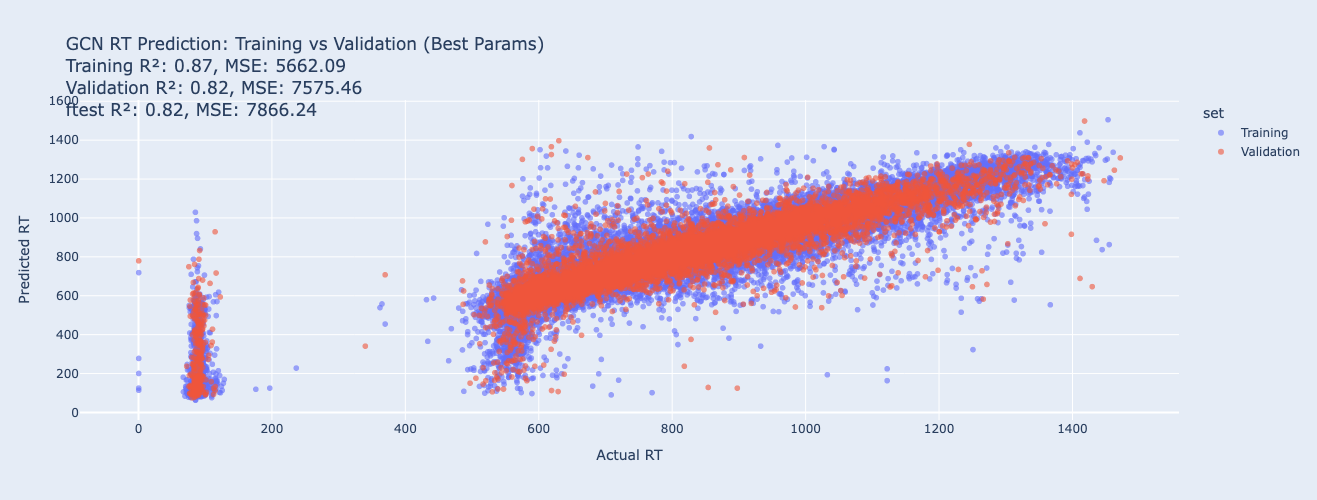

In [ ]:
import plotly.express as px
import pandas as pd

# Convert tensors to numpy
train_true_np = train_y_true.numpy()
train_pred_np = train_y_pred.squeeze().numpy()
valid_true_np = valid_y_true.numpy()
valid_pred_np = valid_y_pred.squeeze().numpy()

train_df = pd.DataFrame({'rt': train_true_np, 'predicted_rt': train_pred_np, 'set': 'Training'})
valid_df = pd.DataFrame({'rt': valid_true_np, 'predicted_rt': valid_pred_np, 'set': 'Validation'})
combined_data = pd.concat([train_df, valid_df])

# Scatter plot for training and validation sets
title_text = (
    f"GCN RT Prediction: Training vs Validation (Best Params)<br>"
    f"Training R²: {train_r2:.2f}, MSE: {train_mse:.2f}<br>"
    f"Validation R²: {valid_r2:.2f}, MSE: {valid_mse:.2f}<br>"
    f"ftest R²: {ftest_r2:.2f}, MSE: {ftest_mse:.2f}"
)

fig = px.scatter(
    combined_data, x='rt', y='predicted_rt', color='set',
    title=title_text,
    labels={'rt': 'Actual RT', 'predicted_rt': 'Predicted RT'},
    opacity=0.6
)

fig.update_layout(
    plot_bgcolor='rgba(229, 236, 246,1)',
    paper_bgcolor='rgba(229, 236, 246,1)',
    width=800,
    height=500
)

fig.show()

In [60]:
torch.save(model,'chronol_bestmolde.pt')

# Model performance visualization

In [9]:
# Reading from spreadsheet
df = pd.read_excel('model_performance_summary.xlsx')  # or pd.read_csv('your_file.csv')

# 1. R² Scores Grouped Bar Chart
fig_r2 = go.Figure()

# Add bars for LGBM
lgbm_df = df[df['Model'] == 'LGBM']
fig_r2.add_trace(go.Bar(
    name='LGBM - Validation',
    x=lgbm_df['Splitting'],
    y=lgbm_df['valid_r2'],
    text=lgbm_df['valid_r2'].round(3),
    textposition='auto',
    marker_color='#636EFA', # Plotly Blue
    hovertemplate='<b>Model:</b> LGBM<br><b>Splitting:</b> %{x}<br><b>R²:</b> %{y:.3f}<br><b>Dataset:</b> Validation<extra></extra>'
))

fig_r2.add_trace(go.Bar(
    name='LGBM - Test',
    x=lgbm_df['Splitting'],
    y=lgbm_df['ftest_r2'],
    text=lgbm_df['ftest_r2'].round(3),
    textposition='auto',
    marker_color='rgba(99, 110, 250, 0.5)', # Light Plotly Blue
    hovertemplate='<b>Model:</b> LGBM<br><b>Splitting:</b> %{x}<br><b>R²:</b> %{y:.3f}<br><b>Dataset:</b> Test<extra></extra>'
))

# Add bars for GCN
gcn_df = df[df['Model'] == 'GCN']
fig_r2.add_trace(go.Bar(
    name='GCN - Validation',
    x=gcn_df['Splitting'],
    y=gcn_df['valid_r2'],
    text=gcn_df['valid_r2'].round(3),
    textposition='auto',
    marker_color='#EF553B', # Plotly Red
    hovertemplate='<b>Model:</b> GCN<br><b>Splitting:</b> %{x}<br><b>R²:</b> %{y:.3f}<br><b>Dataset:</b> Validation<extra></extra>'
))

fig_r2.add_trace(go.Bar(
    name='GCN - Test',
    x=gcn_df['Splitting'],
    y=gcn_df['ftest_r2'],
    text=gcn_df['ftest_r2'].round(3),
    textposition='auto',
    marker_color='rgba(239, 85, 59, 0.5)', # Light Plotly Red
    hovertemplate='<b>Model:</b> GCN<br><b>Splitting:</b> %{x}<br><b>R²:</b> %{y:.3f}<br><b>Dataset:</b> Test<extra></extra>'
))

fig_r2.update_layout(
    # title='R² Scores by Model and Splitting Method',
    plot_bgcolor='rgba(229, 236, 246,1)',
    paper_bgcolor='rgba(229, 236, 246,1)',
    # xaxis_title='Splitting Method',
    yaxis_title='R²',
    yaxis_range=[0, 1],
    barmode='group',
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    margin=dict(l=20, r=20, t=40, b=20), # Reduce margins
    # legend_title='Model & Dataset'
)

# 2. MSE Scores Grouped Bar Chart
fig_mse = go.Figure()

# Add bars for LGBM
fig_mse.add_trace(go.Bar(
    name='LGBM - Validation',
    x=lgbm_df['Splitting'],
    y=lgbm_df['valid_mse'],
    text=lgbm_df['valid_mse'].round(0),
    textposition='auto',
    marker_color='#636EFA', # Plotly Blue
    hovertemplate='<b>Model:</b> LGBM<br><b>Splitting:</b> %{x}<br><b>MSE:</b> %{y:,.0f}<br><b>Dataset:</b> Validation<extra></extra>'
))

fig_mse.add_trace(go.Bar(
    name='LGBM - ftest',
    x=lgbm_df['Splitting'],
    y=lgbm_df['ftest_mse'],
    text=lgbm_df['ftest_mse'].round(0),
    textposition='auto',
    marker_color='rgba(99, 110, 250, 0.5)', # Light Plotly Blue
    hovertemplate='<b>Model:</b> LGBM<br><b>Splitting:</b> %{x}<br><b>MSE:</b> %{y:,.0f}<br><b>Dataset:</b> Test<extra></extra>'
))

# Add bars for GCN
fig_mse.add_trace(go.Bar(
    name='GCN - Validation',
    x=gcn_df['Splitting'],
    y=gcn_df['valid_mse'],
    text=gcn_df['valid_mse'].round(0),
    textposition='auto',
    marker_color='#EF553B', # Plotly Red
    hovertemplate='<b>Model:</b> GCN<br><b>Splitting:</b> %{x}<br><b>MSE:</b> %{y:,.0f}<br><b>Dataset:</b> Validation<extra></extra>'
))

fig_mse.add_trace(go.Bar(
    name='GCN - ftest',
    x=gcn_df['Splitting'],
    y=gcn_df['ftest_mse'],
    text=gcn_df['ftest_mse'].round(0),
    textposition='auto',
    marker_color='rgba(239, 85, 59, 0.5)', # Light Plotly Red
    hovertemplate='<b>Model:</b> GCN<br><b>Splitting:</b> %{x}<br><b>MSE:</b> %{y:,.0f}<br><b>Dataset:</b> Test<extra></extra>'
))

fig_mse.update_layout(
    # title='MSE Scores by Model and Splitting Method',
    plot_bgcolor='rgba(229, 236, 246,1)',
    paper_bgcolor='rgba(229, 236, 246,1)',
    #xaxis_title='Splitting Method',
    yaxis_title='MSE',
    barmode='group',
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    margin=dict(l=20, r=20, t=40, b=20), # Reduce margins
)

# Show the figures
fig_r2.show()
fig_mse.show()

# Save the figures
# fig_r2.write_html("r2_scores.html")
# fig_mse.write_html("mse_scores.html")